### 2448509 Ashwin Rajan LAB 1 Task 2

In [ ]:
# =====================================================
# Q2. Source–Filter Model: build synthetic speech, then sample & reconstruct
# =====================================================

# ---- Q2-(a): Generate a source signal and apply a vocal-tract filter ----
def impulse_train(fs, f0, duration):
    """Generate an impulse train with period = fs/f0 (unit impulses)."""
    n = int(fs*duration)
    out = np.zeros(n)
    period = max(1, int(round(fs / f0)))
    out[::period] = 1.0
    return out

def resonator_biquad_coeffs(f, fs, r=0.98):
    """
    Return (b, a) for a simple 2nd-order resonator centered at frequency f (Hz),
    radius r (0<r<1). Transfer: H(z) = 1 / (1 - 2 r cos(2πf/fs) z^-1 + r^2 z^-2)
    """
    omega = 2.0 * pi * f / fs
    a1 = -2.0 * r * np.cos(omega)
    a2 = r**2
    b = np.array([1.0, 0.0, 0.0])  # numerator
    a = np.array([1.0, a1, a2])    # denominator
    return b, a

def biquad_filter(b, a, x):
    """Direct form IIR filter for 2nd-order section (no SciPy needed)."""
    y = np.zeros_like(x)
    # a[0] assumed 1
    for n in range(len(x)):
        x_n = x[n]
        y_n = b[0]*x_n
        if n-1 >= 0:
            y_n += b[1]*x[n-1] - a[1]*y[n-1]
        if n-2 >= 0:
            y_n += b[2]*x[n-2] - a[2]*y[n-2]
        y[n] = y_n
    return y

def vocal_tract_filter(x, fs, formants=((700, 0.98), (1200, 0.985), (2500, 0.99))):
    """
    Cascade of 2nd-order resonators approximating vocal tract formants.
    formants: list of (frequency_Hz, radius_r) pairs.
    """
    y = x.copy()
    for f, r in formants:
        b, a = resonator_biquad_coeffs(f, fs, r=r)
        y = biquad_filter(b, a, y)
    return y

# Build the source: voiced + unvoiced segments
q2_fs = master_fs  # Work at high rate first
q2_duration = 1.0

In [ ]:
# Q2-(a)(i): Source signal
T_voiced = 0.6
T_unvoiced = q2_duration - T_voiced
src_voiced = impulse_train(q2_fs, f0=120.0, duration=T_voiced)  # glottal pulse train (idealized)
src_unvoiced = np.random.randn(int(q2_fs*T_unvoiced)) * 0.1     # white noise (unvoiced)
src = np.concatenate([src_voiced, src_unvoiced])

# Q2-(a)(ii): Apply vocal-tract filter (3 formants as an example vowel-like color)
q2_filtered = vocal_tract_filter(src, q2_fs, formants=((700, 0.98), (1200, 0.985), (2500, 0.99)))
q2_filtered = normalize(q2_filtered)



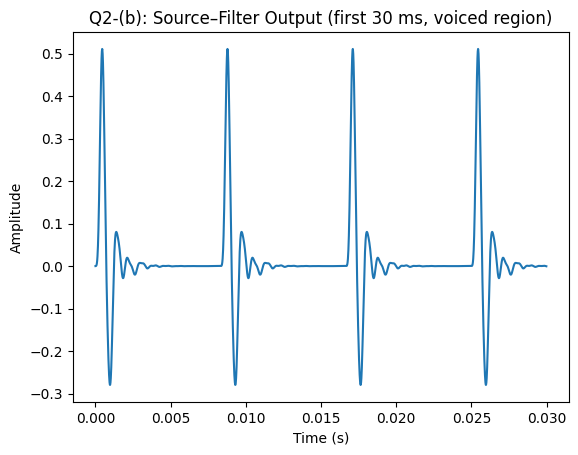

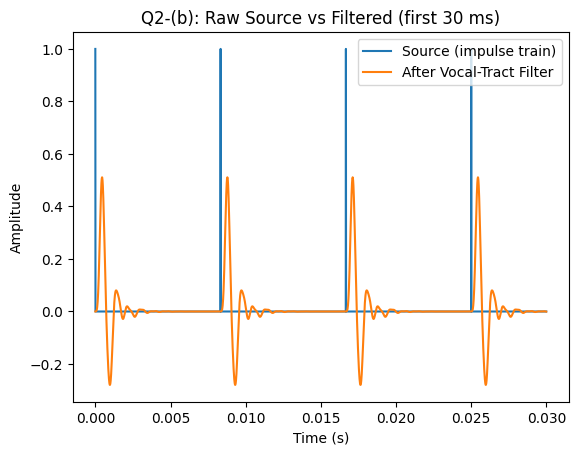

In [ ]:
# ---- Q2-(b): Plot the generated speech and show filter effect ----
tt = np.arange(len(q2_filtered)) / q2_fs

plt.figure()
plt.title("Q2-(b): Source–Filter Output (first 30 ms, voiced region)")
plt.plot(tt[:int(q2_fs*0.03)], q2_filtered[:int(q2_fs*0.03)])
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

plt.figure()
plt.title("Q2-(b): Raw Source vs Filtered (first 30 ms)")
plt.plot(tt[:int(q2_fs*0.03)], src[:int(q2_fs*0.03)], label="Source (impulse train)")
plt.plot(tt[:int(q2_fs*0.03)], q2_filtered[:int(q2_fs*0.03)], label="After Vocal-Tract Filter")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

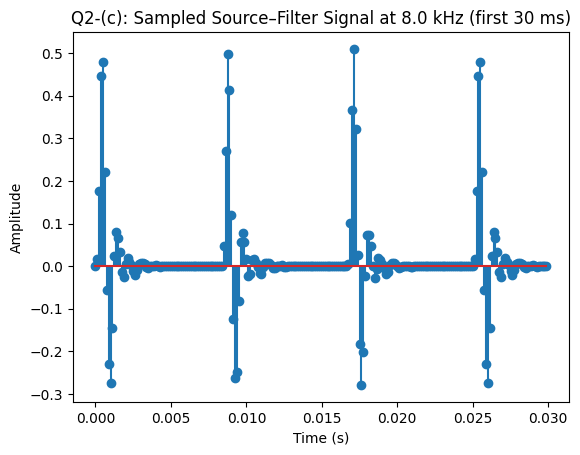

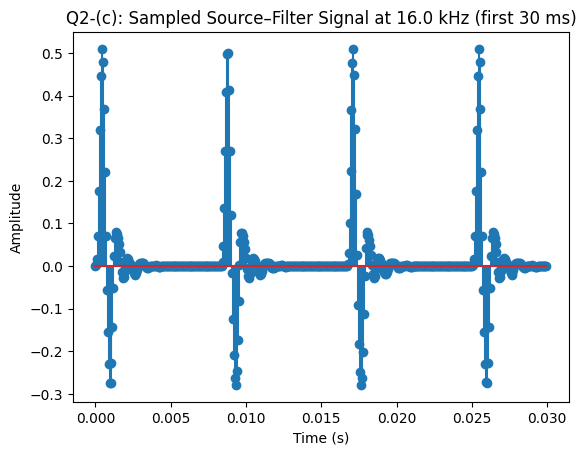

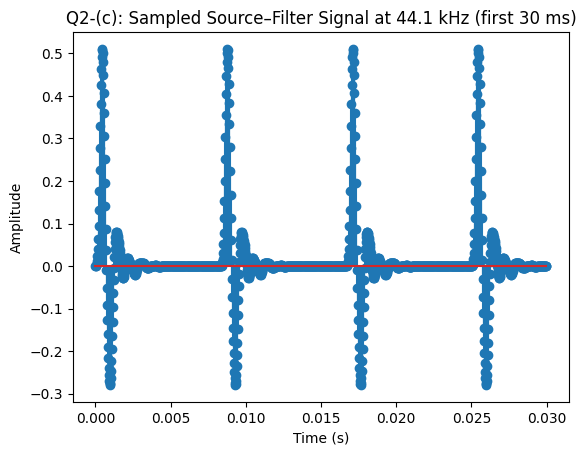

In [ ]:
# ---- Q2-(c): Sample at 8k, 16k, 44.1k ----
q2_sample_rates = [8000, 16000, 44100]
q2_sampled = {fs: resample_by_indexing(q2_filtered, q2_fs, fs) for fs in q2_sample_rates}

for fs in q2_sample_rates:
    tw = np.arange(len(q2_sampled[fs])) / fs
    plt.figure()
    plt.title(f"Q2-(c): Sampled Source–Filter Signal at {fs/1000:.1f} kHz (first 30 ms)")
    nwin = int(fs * 0.03)
    plt.stem(tw[:nwin], q2_sampled[fs][:nwin])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

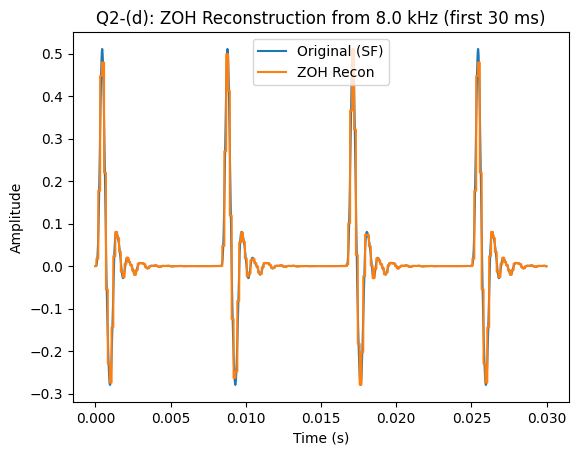

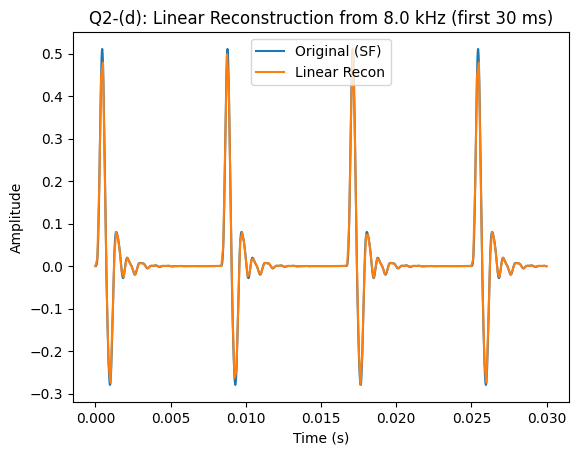

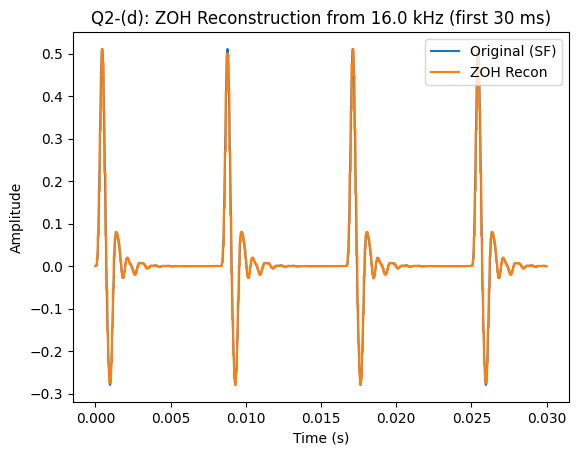

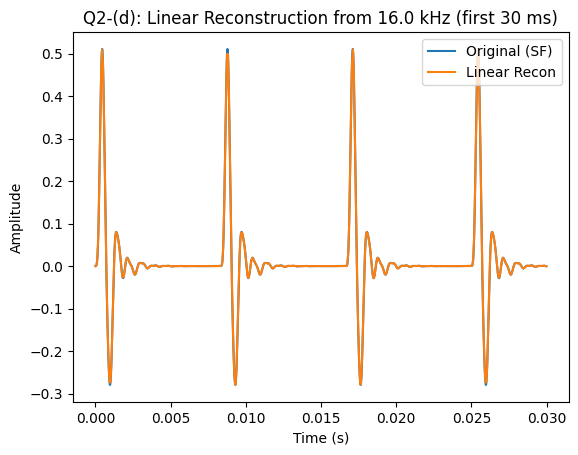

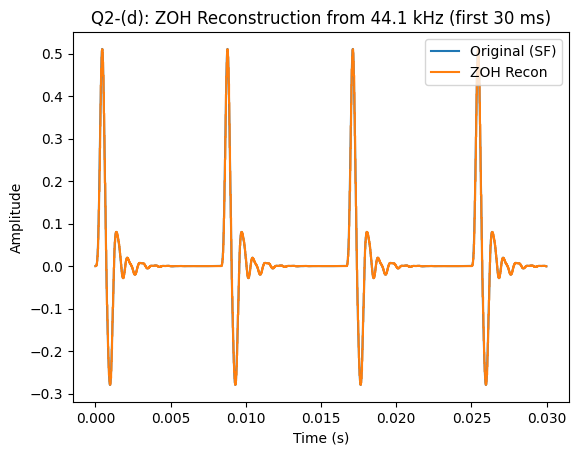

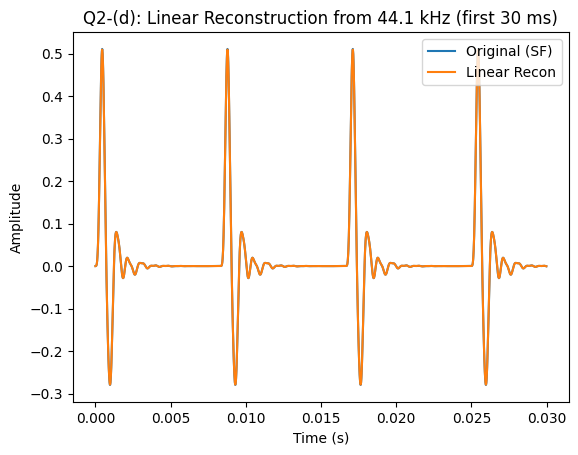

In [ ]:
# ---- Q2-(d): Reconstruct using ZOH and Linear back to the original high rate ----
q2_recon_zoh = {}
q2_recon_lin = {}
for fs in q2_sample_rates:
    q2_recon_zoh[fs] = zero_order_hold_upsample(q2_sampled[fs], fs, q2_fs)
    q2_recon_lin[fs] = linear_interpolate_upsample(q2_sampled[fs], fs, q2_fs)

    Nw = int(q2_fs * 0.03)
    tw = np.arange(Nw) / q2_fs

    plt.figure()
    plt.title(f"Q2-(d): ZOH Reconstruction from {fs/1000:.1f} kHz (first 30 ms)")
    plt.plot(tw, q2_filtered[:Nw], label="Original (SF)")
    plt.step(tw, q2_recon_zoh[fs][:Nw], where='post', label="ZOH Recon")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    plt.figure()
    plt.title(f"Q2-(d): Linear Reconstruction from {fs/1000:.1f} kHz (first 30 ms)")
    plt.plot(tw, q2_filtered[:Nw], label="Original (SF)")
    plt.plot(tw, q2_recon_lin[fs][:Nw], label="Linear Recon")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

In [ ]:
# ---- Q2-(e): Compute MSE between original (source–filter) and reconstructions ----
rows_q2 = []
for fs in q2_sample_rates:
    err_zoh = mse(q2_filtered, q2_recon_zoh[fs])
    err_lin = mse(q2_filtered, q2_recon_lin[fs])
    rows_q2.append({"Sampling Rate (Hz)": fs, "MSE (ZOH)": err_zoh, "MSE (Linear)": err_lin})

df_q2 = pd.DataFrame(rows_q2).sort_values("Sampling Rate (Hz)")
print("\n=== Q2 MSE Results (Source–Filter) ===")
print(df_q2.to_string(index=False))


=== Q2 MSE Results (Source–Filter) ===
 Sampling Rate (Hz)  MSE (ZOH)  MSE (Linear)
               8000   0.001753  1.515685e-04
              16000   0.000460  9.947450e-06
              44100   0.000057  2.462747e-07
